# Introduction

### Context

Insurance All is a company that provides health insurance for customers. The development team is analyzing the possibility of offering a new product to your policyholders: auto insurance.

Just like health insurance, the customers of this new auto insurance plan need to pay an annual amount to Insurance All company to obtain assured value by the company, to the cost of an eventual accident of damage to the vehicle.

Insurance All company conducted a survey for approximately 380,000 customers about their interest in joining a new auto insurance product last year. All customers expressed interest or not in purchasing auto insurance and these response were saved in a database along with other customers attributes.

The development team selected 127 thousand new customers who did not respond to the survey to participate in a campaign, which they will receive the offer of a new auto insurance product. The offer will be made by the sales team trough telephone calls.

However, the sales team has the capacity to make 20 thousand calls within campaign period.

### The Challenge

In that context, I was hired as a Data Science consultant to build a model that predicts whether or not the customer would be interested in auto insurance.
With my solution, the sales team hopes to be able to prioritize the people with the greatest interest in the new product and thus, optimize the campaign making only contacts with customers most likely to purchase the insurance.

As a result of my consultancy, I will need to deliver a report containing some analysis and answers to the following questions:

1. Main insights on the most relevant attributes of customers interested in purchasing auto insurance. 
2. What percentage of customers interested in purchasing auto insurance will the sales team be able to reach by making 20,000 calls? 
3. If the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?
4. How many calls the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

# 0.0. Imports

In [61]:
# Import the relevant libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistics
from scipy import stats

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Load images
from IPython.display import Image

# Warning
import warnings
warnings.filterwarnings( 'ignore' )

# Feature selection
from boruta import BorutaPy

# Scalers
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

# Save files
import pickle

# Model selection
from sklearn.model_selection import train_test_split

# Machine Learning models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model's cross-validation
from sklearn.model_selection import cross_validate, RandomizedSearchCV

# Model's metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, make_scorer
import scikitplot as skplt

#Handling Oversampling
from imblearn.over_sampling import SMOTE

## 0.1 Helper Functions

In [2]:
# Percentual plot
def percentual_count(var: str, dataset: pd.DataFrame):
    ax = sns.countplot(y=var, data=dataset)
    total = len(dataset[var])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
    return plt.show()

In [3]:
def cramers_corrected_stat(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
    """
    # Calculate confusion matrix
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    # Calculate chi2
    chi2 = stats.chi2_contingency(cm)[0]
    # Calculate chi2 correction
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    # K correction
    kcorr = k - (k-1)**2/(n-1)
    # R correction
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [4]:
# Model's performance
def ml_scores(model_name, y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    
    return pd.DataFrame({'Accuracy': accuracy, 
                         'Precision': precision, 
                         'Recall': recall,
                         'F1': f1,
                         'ROC': roc}, 
                        index=[model_name])

In [5]:
# Model's performance function
def cross_val_performance(model, y_train, y_pred):
    # define scoring metrics
    scoring = {'Accuracy': 'accuracy',
               'Precision': make_scorer(precision_score),
               'Recall': make_scorer(recall_score),
               'F1': make_scorer(f1_score),
               'ROC': make_scorer(roc_auc_score)}

    # calculate scores with cross_validate
    scores = cross_validate(model, y_train, y_pred, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(np.round(performance.mean(), 4).astype(str) + ' +/- ' + np.round(performance.std()*2,4).astype(str)).T
    return performance

In [6]:
# Confusion Matrix function
def conf_matrix(y_train, y_pred):
    cm = confusion_matrix(y_train, y_pred)
    cm_data = pd.DataFrame(cm, columns = ['Positive', 'Negative'], index=['Positive', 'Negative'])
    sns.heatmap(cm_data, annot=True, cmap='Blues', fmt='d', annot_kws={'size': 24}).set_title('Confusion Matrix')

    return plt.show()

In [7]:
# Settings
def settings():
   plt.style.use('bmh')
   plt.rcParams['figure.figsize'] = [10, 4]
settings()

# 1.0. Data

## 1.1. Load the Data

In [8]:
# Load train data
df_train = pd.read_csv('dataset/train.csv')

# Load test data
df_test = pd.read_csv('dataset/test.csv')

# Load sample submission data
df_ss = pd.read_csv('dataset/sample_submission.csv')

In [9]:
# Creating full dataset

# Merge test with sample submission
df_test_1 = pd.merge(df_test, df_ss, how='right')

# Concating both data
df = pd.concat([df_train, df_test_1])

df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.2. Data Dimension

In [10]:
print(f'The shape of Dataset is: {df.shape}')

The shape of Dataset is: (508146, 12)


## 1.4. Data Types and Structure

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508146 entries, 0 to 127036
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    508146 non-null  int64  
 1   Gender                508146 non-null  object 
 2   Age                   508146 non-null  int64  
 3   Driving_License       508146 non-null  int64  
 4   Region_Code           508146 non-null  float64
 5   Previously_Insured    508146 non-null  int64  
 6   Vehicle_Age           508146 non-null  object 
 7   Vehicle_Damage        508146 non-null  object 
 8   Annual_Premium        508146 non-null  float64
 9   Policy_Sales_Channel  508146 non-null  float64
 10  Vintage               508146 non-null  int64  
 11  Response              508146 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 50.4+ MB


* No Null values
* Dataset with 3 types: float64(3), int64(6), object(3)

## 1.5. Columns Description

| Variable             | Definition                                                   | DTYPE   |
| :------------------- | :----------------------------------------------------------- | ------- |
| id                   | Unique ID for the customer                                   | int64   |
| Gender               | Gender of the customer                                       | Object  |
| Age                  | Age of the customer                                          | int64   |
| Driving_License      | 0 : Customer does not have DL, 1 : Customer already has DL   | int64   |
| Region_Code          | Unique code for the region of the customer                   | float64 |
| Previously_Insured   | 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance | int64   |
| Vehicle_Age          | Age of the Vehicle                                           | object  |
| Vehicle_Damage       | 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past. | object  |
| Annual_Premium       | The amount customer needs to pay as premium in the year      | float64 |
| Policy*Sales*Channel | Anonymised Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. | float64 |
| Vintage              | Number of Days, Customer has been associated with the company | int64   |
| Response             | 1 : Customer is interested, 0 : Customer is not interested   | int64   |

`Region_Code` and `PolicySalesChannel` are variables with exclusive knowledge of the company, as we analyze from outside the company we do not have the codes meanings.

## 1.6. Descriptive Statistics

### 1.6.1. Numerical Attributes

In [12]:
num_attr = df.select_dtypes(include=['int64', 'float64'])

In [13]:
describe = num_attr.describe().T

describe['range'] = (num_attr.max() - num_attr.min()).tolist()
describe['unique val.'] = num_attr.nunique()
describe['variation coefficient'] = np.round((num_attr.std() / num_attr.mean()), 4).tolist()
describe['skew'] = np.round(num_attr.skew(), 4).tolist()
describe['kurtosis'] = np.round(num_attr.kurtosis(), 4).tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,unique val.,variation coefficient,skew,kurtosis
id,508146.0,254073.500000,146689.259281,1.0,127037.25,254073.5,381109.75,508146.0,508145.0,508146,0.5773,-0.0000,-1.2000
Age,508146.0,38.808413,15.500179,20.0,25.00,36.0,49.00,85.0,65.0,66,0.3994,0.6728,-0.5647
Driving_License,508146.0,0.997936,0.045388,0.0,1.00,1.0,1.00,1.0,1.0,2,0.0455,-21.9412,479.4167
Region_Code,508146.0,26.406572,13.224921,0.0,15.00,28.0,35.00,52.0,52.0,53,0.5008,-0.1170,-0.8650
Previously_Insured,508146.0,0.458667,0.498289,0.0,0.00,0.0,1.00,1.0,1.0,2,1.0864,0.1659,-1.9725
Annual_Premium,508146.0,30554.453041,17146.574625,2630.0,24381.00,31661.0,39403.75,540165.0,537535.0,52062,0.5612,1.6002,30.0479
Policy_Sales_Channel,508146.0,111.975838,54.246027,1.0,26.00,133.0,152.00,163.0,162.0,157,0.4844,-0.8969,-0.9774
Vintage,508146.0,154.340123,83.668793,10.0,82.00,154.0,227.00,299.0,289.0,290,0.5421,0.0026,-1.2003
Response,508146.0,0.091922,0.288917,0.0,0.00,0.0,0.00,1.0,1.0,2,3.1430,2.8249,5.9800


* `Driving_License` has bigger kurtosis and skew, but it's a categorical variable;
* `Annual_Premium` has bigger range and high kurtosis;
* `id` can be removed.

### 1.6.2. Categorical Attributes

In [14]:
cat_attr = df.select_dtypes(include='object')
cat_attr.describe().T

,count,unique,top,freq
Gender,508146,2,Male,274325
Vehicle_Age,508146,3,1-2 Year,267015
Vehicle_Damage,508146,2,Yes,256248


# 2.0. Hypothesis Creation

## 2.1. Mind Map Hypothesis

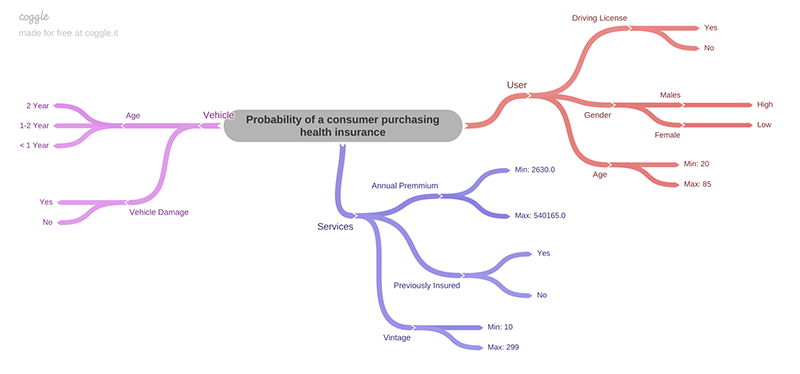

In [15]:
Image('img/Probability_of_a_consumer_purchasing_health_insurance.jpg')

## 2.2. Hypothesis Creation

### 2.2.1. User
1. Males represent 70% of customers with Health Insurance
2. Most health insurance customers are in their 40s
3. All customers with Health Insurance has driving license

### 2.2.2. Vehicle
1. Vehicles under age 1 represents mojority of customers with Health Insurance
2. All Vehicle with damage status represents the majority of customers with Health Insurance

### 2.2.3 Services
1. People with 100 days or more of association with the company are customers
2. Most People with Previous Insured acquire Health Insurance
3. Low fee(annual premium) brings more customers

# 3.0. Feature Engineering

In [16]:
df2 = df.copy()

In [17]:
# Column week creation
df2['week_vintage'] = df2['Vintage'].apply(lambda x: np.ceil(x/7).astype('int'))

# Column month creation
df2['month_vintage'] = df2['Vintage'].apply(lambda x: np.ceil(x/30).astype('int'))

The human age is classified into four categories as Child (0-12 years), Adolescence (13-18 years), Adult (19-59 years) and Senior Adult (60 years and above) which is discussed in the paper.

In [18]:
df2['age_class'] = df2['Age'].apply(lambda x: 'adult' if x < 60 else 'senior')

# 4.0 Exploratory Data Analysis

In [19]:
df3 = df2.copy()

## 4.1. Univariate Analysis

### 4.1.1. Target Variable

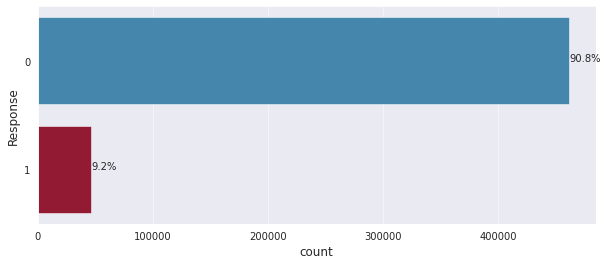

0    461436
1     46710
Name: Response, dtype: int64


In [20]:
sns.set_style('darkgrid')
percentual_count('Response', df3)
print(df3.Response.value_counts())

* The customer with interest in health insurance is approximately 9%.
* Our data is imbalanced.

### 4.1.2. Numerical Variables Distribution

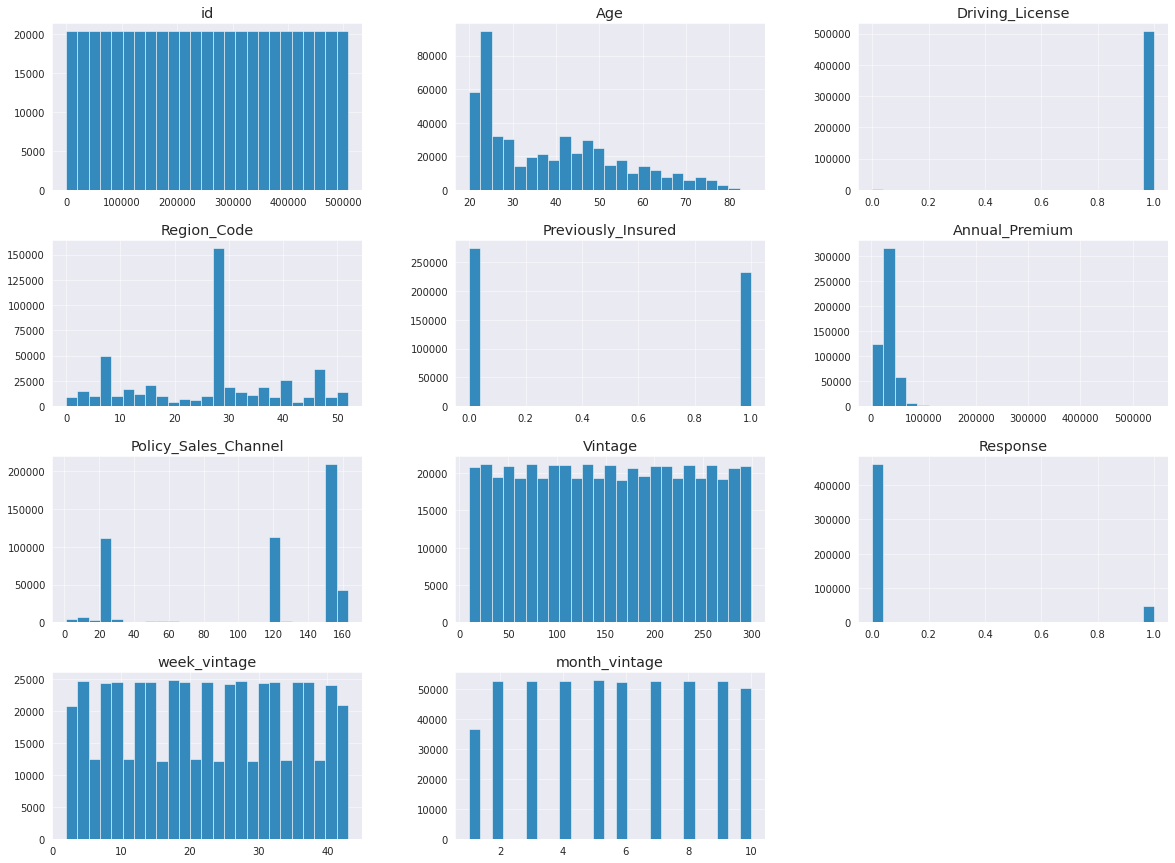

In [21]:
# Plot numerical
df3.select_dtypes(exclude='object').hist(figsize=(20,15), bins=25)
plt.show()

### 4.1.3. Categorical Variable

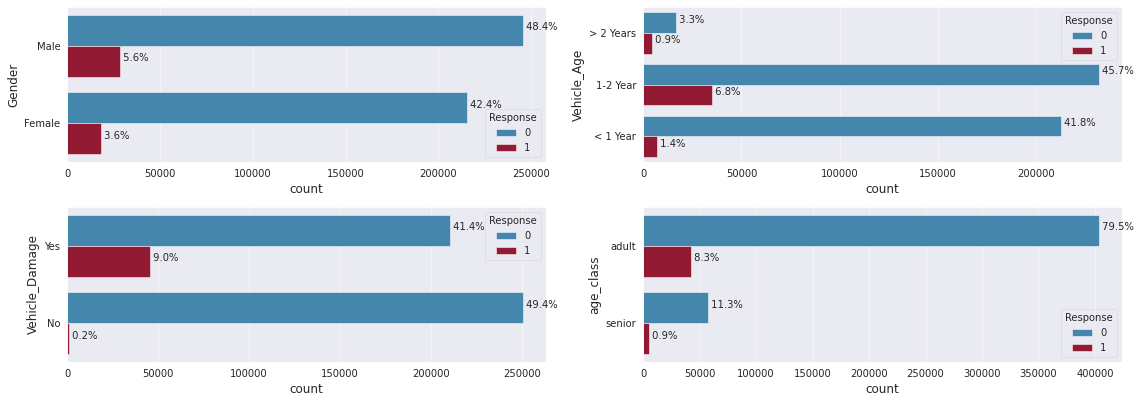

In [22]:
plt.figure(figsize=(16,8))
cat_attributes = df3.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes, hue=df3['Response'])
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1
plt.tight_layout()

## 4.2. Bivariate Analysis

### H1. Males represent 70% of customers with Health Insurance.
**FALSE** : Males represent 61.1%.

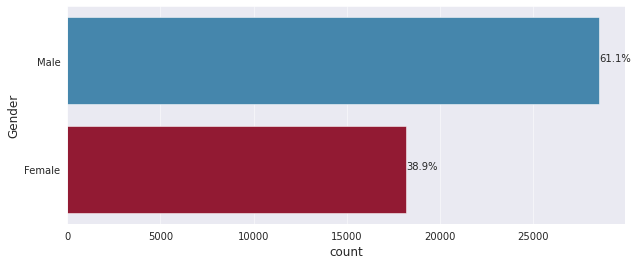

In [23]:
# Dataset with Response = 1
aux1 = df3[df3.Response == 1]

# countplot
percentual_count('Gender', aux1)

### H2. Most health insurance customers are in their 40s.
**TRUE**: Customers in their 40s are the majority  

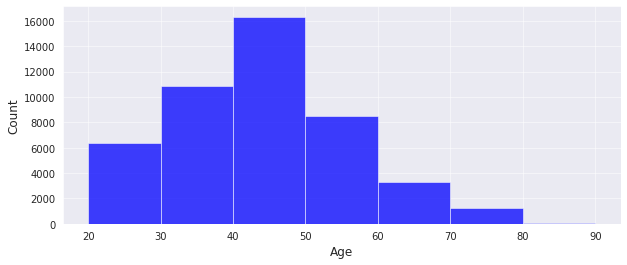

In [24]:
sns.histplot(x='Age', data=aux1, bins = range(20,100,10))
plt.show()

### H3. All customers with Health Insurance has driving license.
**True**: 99.9% of the customers with Health Insurance has driving license

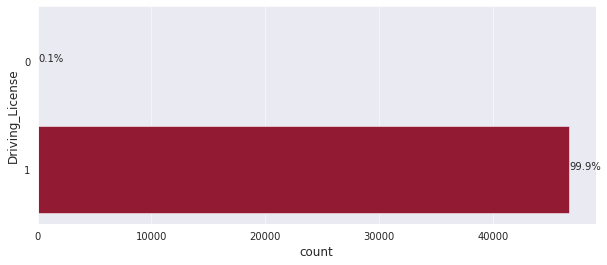

In [25]:
percentual_count('Driving_License', aux1)

### H4.Vehicles under age 1 represents mojority of customers with Health Insurance.
**FALSE**: Vehicles between 1 and 2 are mojority.

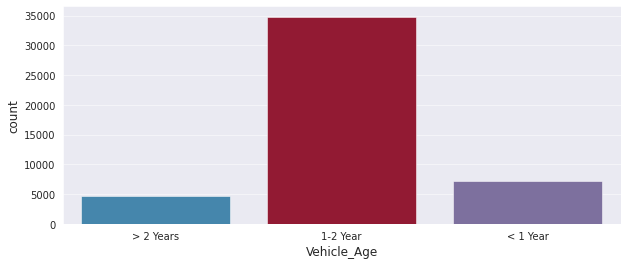

In [26]:
sns.countplot(x='Vehicle_Age', data= aux1)
plt.show()

### H5. All Vehicle with damage status represents the majority of customers with Health Insurance.
**TRUE**: Vehicle with damage status represents 97.9% of customers.

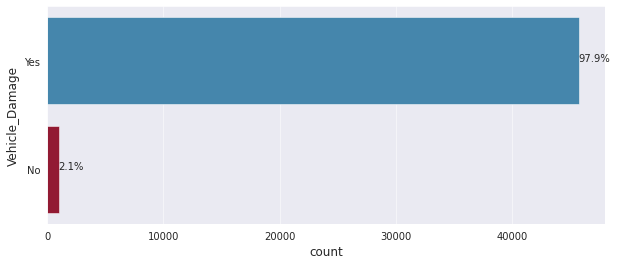

In [27]:
percentual_count('Vehicle_Damage', aux1)

### H6. People with 100 days or more of association with the company are customers.
**TRUE**: It is a uniform distribution.

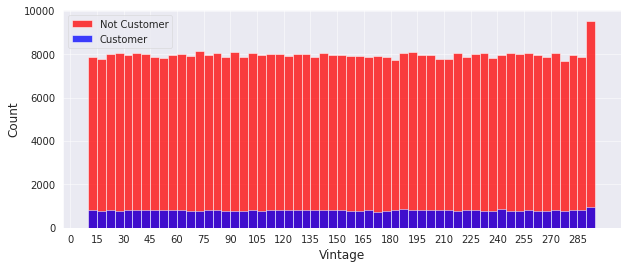

In [28]:
aux6 = df3[df3.Response == 0]
plt.figure(figsize=(10,4))
sns.histplot(x=aux6.Vintage, bins=range(10,300,5), label='Not Customer', color='r')
sns.histplot(x=aux1.Vintage, bins=range(10,300,5), label='Customer')
plt.xticks(np.arange(0,300, step=15))
plt.legend()
plt.show()

### H7. Most People with Previous Insured acquire Health Insurance.
**TRUE**: 99.7% are Previous Insured.

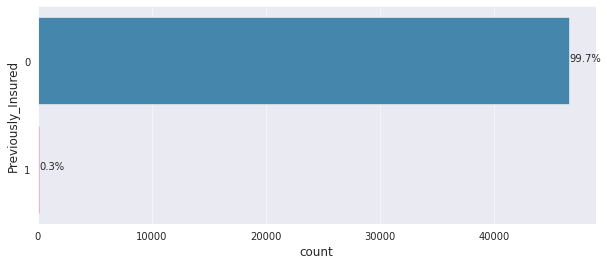

In [29]:
percentual_count('Previously_Insured', aux1)

### H8. Low fee(annual premium) brings more customers.
**TRUE**: Customers who pay less annual premium are the majority.

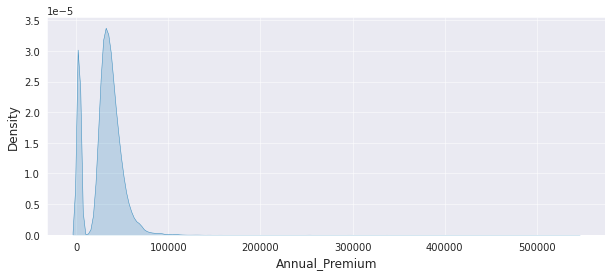

In [30]:
sns.kdeplot(x='Annual_Premium', data=aux1, shade=True)
plt.show()

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

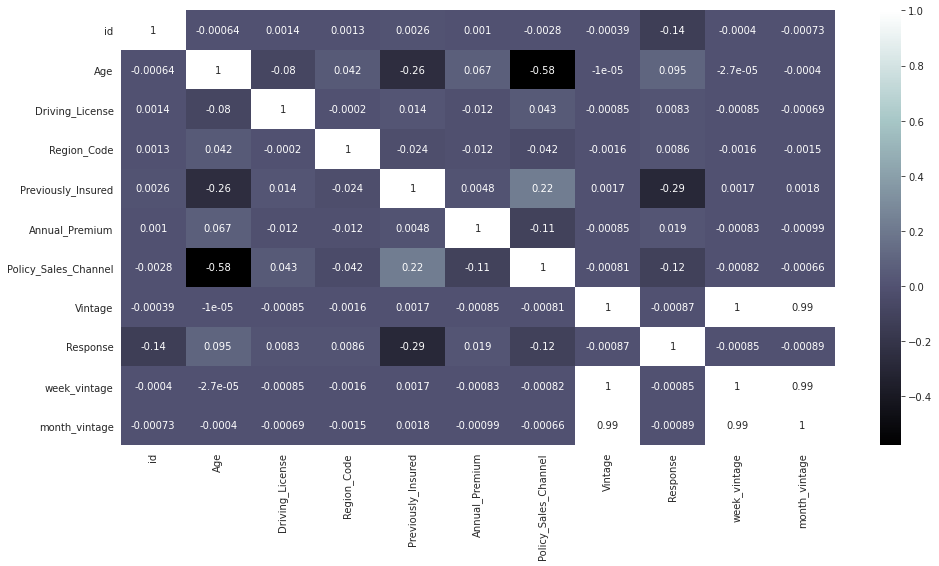

In [31]:
# Correlation by pearson method
correlation = df3.select_dtypes(exclude='object').corr(method='pearson')

# set up figure
plt.figure(figsize=(16,8))
sns.heatmap(correlation, annot=True, cmap='bone')
plt.show()

### 4.3.2. Categorical Variables

In [32]:
dict_for_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_for_corr[column] = {}

    for column2 in columns:
        dict_for_corr[column][column2] = cramers_corrected_stat(cat_attributes[column], cat_attributes[column2])

corr_cat = pd.DataFrame(dict_for_corr)

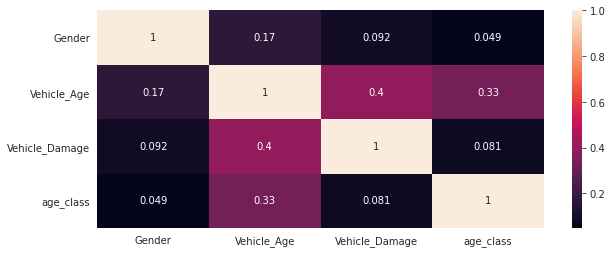

In [33]:
plt.figure(figsize=(10,4))
sns.heatmap(corr_cat, annot=True)
plt.show()

# 5.0. Data Preparation

In [34]:
df4 = df3.copy()

## 5.1. Tranformation

In [35]:
gender_map= {'Male':0,'Female':1}
vehicle_age_map= {'< 1 Year':0,'1-2 Year':1,'> 2 Years':2}
vehicle_damage_map= {'Yes':1,'No':0}
le = LabelEncoder()

df4['Gender']= df4['Gender'].map(gender_map)
df4['Vehicle_Age']= df4['Vehicle_Age'].map(vehicle_age_map)
df4['Vehicle_Damage']= df4['Vehicle_Damage'].map(vehicle_damage_map)
df4['age_class'] = le.fit_transform(df4[['age_class']])
df4.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,week_vintage,month_vintage,age_class
0,1,0,44,1,28.0,0,2,1,40454.0,26.0,217,1,31,8,0
1,2,0,76,1,3.0,0,1,0,33536.0,26.0,183,0,27,7,1
2,3,0,47,1,28.0,0,2,1,38294.0,26.0,27,1,4,1,0
3,4,0,21,1,11.0,1,0,0,28619.0,152.0,203,0,29,7,0
4,5,1,29,1,41.0,1,0,0,27496.0,152.0,39,0,6,2,0


In [36]:
df4.Region_Code.unique()

array([28.,  3., 11., 41., 33.,  6., 35., 50., 15., 45.,  8., 36., 30.,
       26., 16., 47., 48., 19., 39., 23., 37.,  5., 17.,  2.,  7., 29.,
       46., 27., 25., 13., 18., 20., 49., 22., 44.,  0.,  9., 31., 12.,
       34., 21., 10., 14., 38., 24., 40., 43., 32.,  4., 51., 42.,  1.,
       52.])

In [37]:
# One Hot Encoder with pandas dummies
df4 = pd.get_dummies(df4, prefix=['Vehicle_Age'], columns=['Vehicle_Age'])

## 5.2. Rescaling

### 5.2.1. Checking Outlier

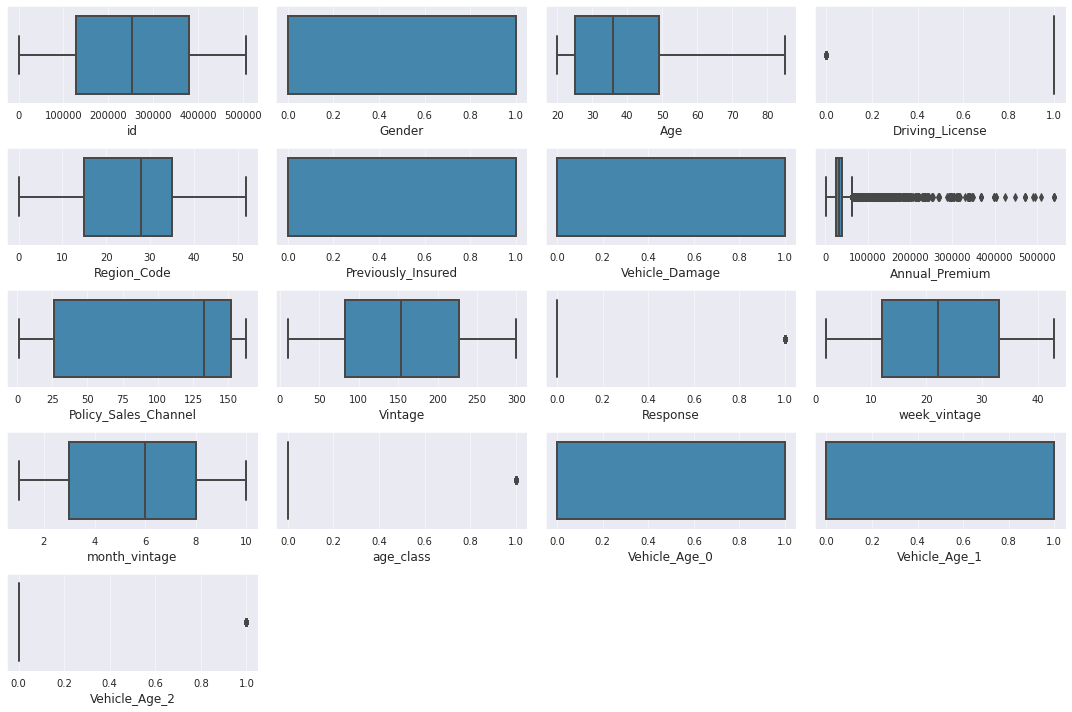

In [38]:
# Numerical columns
df4_num = df4.select_dtypes(exclude='object')

# Checking outliers
plt.figure(figsize=(15, 10))

for i in range(len(df4_num.columns)):
    plt.subplot(5, 4, i + 1)
    sns.boxplot(df4_num[df4_num.columns[i]])
plt.tight_layout()
plt.show()

In [39]:
df5 = df4.copy()

### 5.2.2. Robust Scaler

In [40]:
# Robust Scaler for variables with high outlier influence
rs = RobustScaler()
df5.Annual_Premium = rs.fit_transform(df5[['Annual_Premium']].values)

### 5.2.3. MinMax Scaler

In [41]:
# MinMaxScaler for variables with low outliers influence
columns = ['Driving_License', 'Vehicle_Age_2', 'Response']
mms = MinMaxScaler()
for i in columns:
      df5[i] = mms.fit_transform(df5[[i]])

## 5.3. Standardization

None of the numerical variables have a normal distribution (see subsection 4.1.2)

# 6.0. Feature Selection

In [42]:
# Removing unnecessary columns
df5 = df5.drop('id',axis=1)

# Preparing dataset
X_boruta = df5.drop('Response',axis=1)
Y_boruta = df5.Response

In [43]:
print(X_boruta.shape)
print(Y_boruta.shape)

(508146, 15)
(508146,)


## 6.1. Boruta as Feature Selector

In [44]:
# Train random forest classifier

# x_train
#x_n = X_boruta.values

# y_train
#y_n = Y_boruta.values.ravel()

# Define Random Forest Classifier
#rf = RandomForestClassifier(n_estimators=200, n_jobs=4, max_depth = 6, class_weight='balanced')

# Define Boruta feature selection method
#feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_n, y_n)

### 6.1.1. Best Features

In [45]:
# Check selected features
#cols_selected_boruta = feat_selector.support_.tolist()
#columns_selected = df5.drop(['Response'], axis=1).loc[:, cols_selected_boruta].columns.tolist()
#columns_selected

In [46]:
columns_selected = ['Gender',
 'Age',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Damage',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'age_class',
 'Vehicle_Age_0',
 'Vehicle_Age_1',
 'Vehicle_Age_2']

## 6.2. Feature Importance

[0.01344029 0.15268589 0.00042493 0.12376174 0.03363395 0.05429761
 0.24460705 0.07428602 0.18322406 0.076088   0.02394682 0.00397339
 0.0081894  0.0052869  0.00215395]


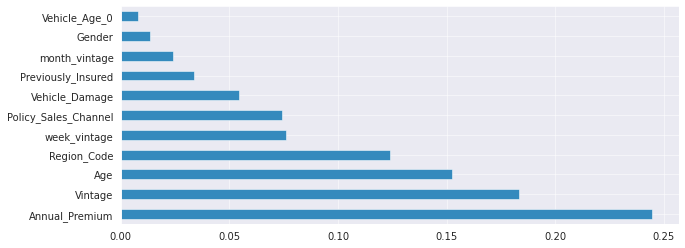

In [47]:
model = RandomForestClassifier()
model.fit(X_boruta,Y_boruta)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_boruta.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

# 7.0. Machine Learning Modelling

## 7.1. Spliting into Train, Valid and Test

In [48]:
# Remove target variable from train set
X = df5.drop('Response', axis=1)
y = df5.Response

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [49]:
# transform validation dataset type
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [50]:
# Since Data Set is imbalanced, SMOTE will apply_train to balance representatoin of Response feature
print("Shape of x_train before over-Sampling:", x_train.shape)
print("Shape of y_train before over-Sampling:", y_train.shape)
print('---'*10)
# SMOTE
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

print("Shape of x_train after over-Sampling:", x_train.shape)
print("Shape of y_train after over-Sampling:", y_train.shape)

Shape of x_train before over-Sampling: (406516, 15)
Shape of y_train before over-Sampling: (406516,)
------------------------------
Shape of x_train after over-Sampling: (738082, 15)
Shape of y_train after over-Sampling: (738082,)


## 7.2. Checkpoint 1

### 7.2.1. Save preprocessed dataset

In [51]:
x_train.to_csv('data/x_train.csv', index=False)
x_test.to_csv('data/x_test.csv', index=False)
y_train.to_csv('data/y_train.csv',index=False)
y_test.to_csv('data/y_test.csv', index=False)

### 7.2.2. Load preprocessed dataset

In [52]:
x_train = pd.read_csv('data/x_train.csv')
x_test = pd.read_csv('data/x_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

In [53]:
# Feat selected
feat_list = columns_selected
x_train_fs = x_train[feat_list]
x_test_fs = x_test[feat_list]

## 7.3. Logistic Regression

### 7.3.1. Logistic Regression model and fit

In [54]:
# Model and fit
lr = LogisticRegression().fit(x_train_fs, y_train)

# Predicting
y_pred_lr = lr.predict(x_test_fs)

### 7.3.2. Logistic Regression performance

In [55]:
performance_lr = ml_scores('Logistic Regression', y_test, y_pred_lr)
performance_lr

,Accuracy,Precision,Recall,F1,ROC
Logistic Regression,0.679829,0.196325,0.815701,0.316479,0.740975


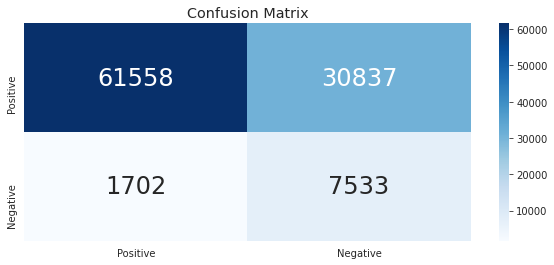

In [56]:
conf_matrix(y_test, y_pred_lr)

## 7.4. Decision Tree Classifier

### 7.4.1. Decision Tree Classifier model and fit

In [57]:
# Model and fit
dt = DecisionTreeClassifier().fit(x_train_fs, y_train)

# Predicting
y_pred_dt = dt.predict(x_test_fs)

### 7.4.2. Decision Tree Classifier performance

In [58]:
dt_performance = ml_scores('Decision Tree', y_test, y_pred_dt)
dt_performance

,Accuracy,Precision,Recall,F1,ROC
Decision Tree,0.808787,0.217005,0.423389,0.286941,0.635349


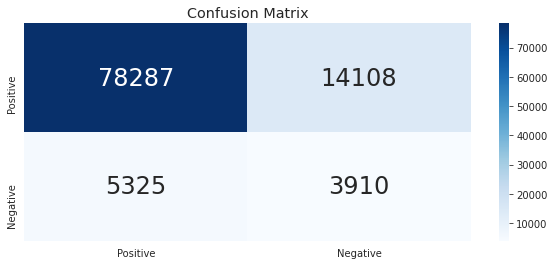

In [59]:
conf_matrix(y_test, y_pred_dt)

## 7.5. XGBoost Classifier

### 7.5.1. XGBoost Classifier model and fit

In [64]:
# Model and fit 
xgb = XGBClassifier().fit(x_train_fs, y_train)

# Predicting
y_pred_xgb = xgb.predict(x_test_fs)

[08:31:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 7.5.2. XGBoost Classifier performance

In [65]:
xgb_performance = ml_scores('XGBoost Classifier', y_test, y_pred_xgb)
xgb_performance

,Accuracy,Precision,Recall,F1,ROC
XGBoost Classifier,0.826646,0.250402,0.455333,0.323114,0.659546


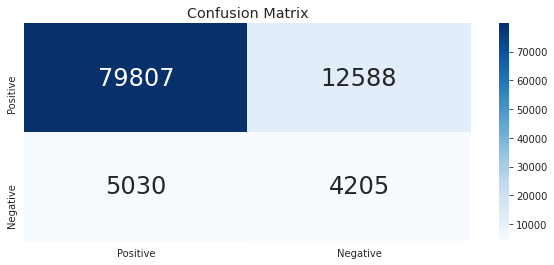

In [66]:
conf_matrix(y_test, y_pred_xgb)

In [67]:
performance = pd.concat(
    [performance_lr, dt_performance, xgb_performance])
performance

,Accuracy,Precision,Recall,F1,ROC
Logistic Regression,0.679829,0.196325,0.815701,0.316479,0.740975
Decision Tree,0.808787,0.217005,0.423389,0.286941,0.635349
XGBoost Classifier,0.826646,0.250402,0.455333,0.323114,0.659546


# 8.0. Cross Validation

## 8.1. Logistic Regression

In [68]:
lr_cv = cross_val_performance(lr, x_train_fs, y_train)
lr_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.7864 +/- 0.0531,0.733 +/- 0.0223,0.8995 +/- 0.1181,0.8072 +/- 0.0634,0.7864 +/- 0.0531


## 8.2. Decision Tree Classifier

In [69]:
dt_cv = cross_val_performance(dt, x_train_fs, y_train)
dt_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.8406 +/- 0.1426,0.8419 +/- 0.0519,0.833 +/- 0.3082,0.8312 +/- 0.2178,0.8406 +/- 0.1426


## 8.3. XGBoost Classifier

In [70]:
xgb_cv = cross_val_performance(xgb, x_train_fs, y_train)
xgb_cv

[08:36:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:37:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:39:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:40:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.8736 +/- 0.1751,0.8577 +/- 0.0693,0.8875 +/- 0.3675,0.8642 +/- 0.2611,0.8736 +/- 0.1751


In [71]:
index = ['Logistic Regression', 'Decision Tree Classifier',
         'XGBoost Classifier']

performance_cv = pd.concat([lr_cv, dt_cv, xgb_cv])
performance_cv.index = index
performance_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
Logistic Regression,0.7864 +/- 0.0531,0.733 +/- 0.0223,0.8995 +/- 0.1181,0.8072 +/- 0.0634,0.7864 +/- 0.0531
Decision Tree Classifier,0.8406 +/- 0.1426,0.8419 +/- 0.0519,0.833 +/- 0.3082,0.8312 +/- 0.2178,0.8406 +/- 0.1426
XGBoost Classifier,0.8736 +/- 0.1751,0.8577 +/- 0.0693,0.8875 +/- 0.3675,0.8642 +/- 0.2611,0.8736 +/- 0.1751


We chose the XGB for performing faster than Random Forest Classifier.

# 9.0. Hyperparameter Fine Tuning

## 9.1. GridSearchCV

In [72]:
# Model
#xgb_tuning = XGBClassifier()

# Parameters
#parameters = {
#    'num_boost_round': [100, 250, 500],
#    'eta': [0.05, 0.1, 0.3],
#    'max_depth': [6, 9, 12],
#    'subsample': [0.9, 1.0],
#    'colsample_bytree': [0.9, 1.0],
#}
# Fit
#xgb_tuning = RandomSearchCV(xgb_tuning, parameters, n_jobs=1, cv=2)
#xgb_tuning.fit(x_train_fs, y_train)

In [73]:
#xgb_tuning.best_params_

## 9.2. Final Machine Learning Model 

In [74]:
param = {'colsample_bytree': 0.6, 'eta': 0.5, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8999999999999999}
 

In [75]:
# Tuned Model
xgb_tuned = XGBClassifier(    
    objective = 'binary:logistic',
    eval_metric = 'error',
    n_estimators = 300,
    eta = 0.5,
    max_depth = 10,
    subsample = 0.9,
    colsample_bytree = 0.6).fit(x_train_fs, y_train)

xgb_tuned_pred = xgb_tuned.predict(x_test_fs)

In [76]:
xgb_tuned_performance = ml_scores("XGBoost Classifier +", y_test, xgb_tuned_pred)

xgb_tuned_performance

,Accuracy,Precision,Recall,F1,ROC
XGBoost Classifier +,0.833061,0.246707,0.407688,0.307397,0.641633


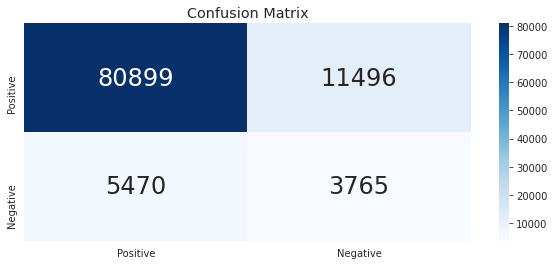

In [77]:
conf_matrix(y_test, xgb_tuned_pred)

## 9.3. Cross Validation Final Model

In [78]:
# XGBoosts tuned cross validation
xgb_tuned_cv = cross_val_performance(xgb_tuned, x_train_fs, y_train)

In [79]:
xgb_tuned_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.8773 +/- 0.1811,0.8672 +/- 0.0713,0.8826 +/- 0.3781,0.8659 +/- 0.2745,0.8773 +/- 0.1811


# 10.0. Results

## 10.1. Single Performance Final

In [80]:
xgb_tuned_performance = xgb_tuned_performance.head(1)
performance_final = pd.concat([performance, xgb_tuned_performance])
performance_final.index = ['Logistic Regression', 'Decision Tree', 'XGBoost Classifier', 'XGBooster Classifier +']
performance_final

,Accuracy,Precision,Recall,F1,ROC
Logistic Regression,0.679829,0.196325,0.815701,0.316479,0.740975
Decision Tree,0.808787,0.217005,0.423389,0.286941,0.635349
XGBoost Classifier,0.826646,0.250402,0.455333,0.323114,0.659546
XGBooster Classifier +,0.833061,0.246707,0.407688,0.307397,0.641633


## 10.2. Real Performance Final

In [81]:
index = ['Logistic Regression', 'Decision Tree', 'XGBoost Classifier', 'XGBoost Classifier +']

performance_final_cv = pd.concat([performance_cv, xgb_tuned_cv])
performance_final_cv.index = index
performance_final_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
Logistic Regression,0.7864 +/- 0.0531,0.733 +/- 0.0223,0.8995 +/- 0.1181,0.8072 +/- 0.0634,0.7864 +/- 0.0531
Decision Tree,0.8406 +/- 0.1426,0.8419 +/- 0.0519,0.833 +/- 0.3082,0.8312 +/- 0.2178,0.8406 +/- 0.1426
XGBoost Classifier,0.8736 +/- 0.1751,0.8577 +/- 0.0693,0.8875 +/- 0.3675,0.8642 +/- 0.2611,0.8736 +/- 0.1751
XGBoost Classifier +,0.8773 +/- 0.1811,0.8672 +/- 0.0713,0.8826 +/- 0.3781,0.8659 +/- 0.2745,0.8773 +/- 0.1811


In [82]:
# Saving XGBoost Classifier Tuned Model
pickle.dump(xgb_tuned, open('models/xgb_tuned.pkl', 'wb'))

## 10.3 Checkpoint 2

### 10.3.1. Saving Dataset

In [83]:
# Saving Dataset
df5.to_csv('data/df6.csv', index=False)

### 10.3.2. Loading Model and Dataset

In [84]:
# Loading XGBoost Classifier +
xgb_tuned = pickle.load(open('models/xgb_tuned.pkl', 'rb'))

# Loading Data
df5 = pd.read_csv('data/df6.csv')

## 10.4. Business Performance

### 1. Main insights on the most relevant attributes of customers interested in purchasing auto insurance. 

* Customers with age between 40 and 50 have more interesting in insurance health.

* Customers who own vehicles between one and two years have more interesting in insurance health.

* Customers who pay less annual premium are more interesting in insurance health.

### 2. What percentage of customers interested in purchasing auto insurance will the sales team be able to reach by making 20,000 calls? 

In [85]:
# creating a copy
df_aux = x_test.copy()
# column for prediction
df_aux['prediction'] = xgb_tuned.predict(df_aux[feat_list])
prob = xgb_tuned.predict_proba(df_aux[feat_list])
df_aux['response'] = y_test
# quantify calls
df_aux['team_calls'] = df_aux.index + 1
# precision
df_aux['precision'] = df_aux['prediction'].cumsum() / df_aux['team_calls']
# recall
df_aux['recall'] = df_aux['prediction'].cumsum() / df_aux['prediction'].sum()

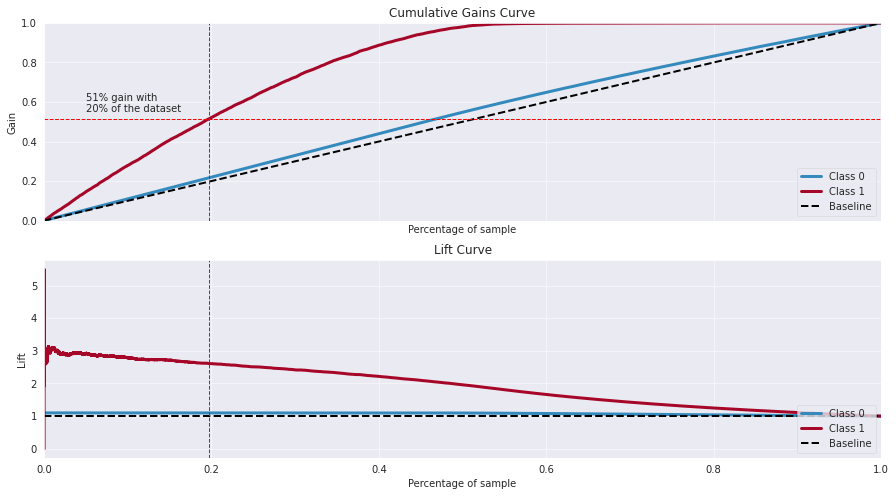

In [86]:
calls_20000 = np.round(20000/len(df_aux), 4)

fig, ax = plt.subplots(2, 1,figsize=(15,8), sharex=True)
skplt.metrics.plot_cumulative_gain(y_test, prob, ax=ax[0])
ax[0].axvline(calls_20000, 0, 1, lw=1, ls='--', color='red')
ax[0].axhline(0.5121, 0, 1,lw=1, ls='--', color='red')
ax[0].annotate("51% gain with \n20% of the dataset", xy=(calls_20000, 0.5121), xytext=(0.05, 0.55), fontsize=10)
skplt.metrics.plot_lift_curve(y_test, prob, ax=ax[1])
ax[1].axvline(calls_20000, 0, 1, lw=1, ls='--', color='red')
plt.show()

In [91]:
print('20,000 calls represents 20% of total data.')
print('The sales team will call to 51% of all interested customers, about 2.6 more time that random method.')

20,000 calls represents 20% of total data.
The sales team will call to 51% of all interested customers, about 2.6 more time that random method.


### 3. If the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?

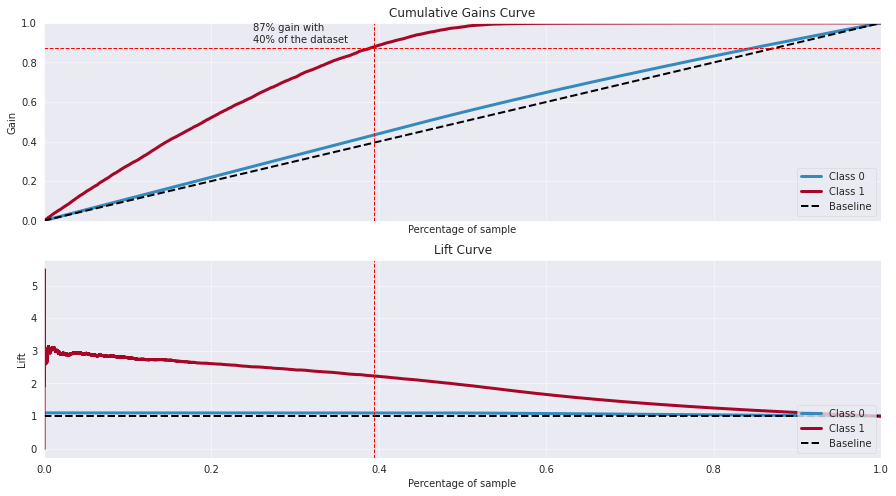

In [87]:
calls_40000 = np.round(40000/len(df_aux), 4)

fig, ax = plt.subplots(2, 1,figsize=(15,8), sharex=True)
skplt.metrics.plot_cumulative_gain(y_test, prob, ax=ax[0])
ax[0].axvline(40000/len(df_aux), 0, 1, lw=1, ls='--', color='red')
ax[0].axhline(np.round(0.8744, 4), 0, 1, lw=1, ls='--', color='red')
ax[0].annotate("87% gain with \n39% of the dataset", xy=(0.3, 0.55), xytext=(0.25, 0.90), fontsize=10)
skplt.metrics.plot_lift_curve(y_test, prob, ax=ax[1])
ax[1].axvline(calls_40000, 0, 1, lw=1, ls='--', color='red')
plt.show()

In [93]:
print('40,000 calls represents 39% of total data.')
print('The sales team will call to 87% of all interested customers, about 3.9 more time that random method.')

40,000 calls represents 39% of total data.
The sales team will call to 87% of all interested customers, about 3.9 more time that random method.


### 4. How many calls the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

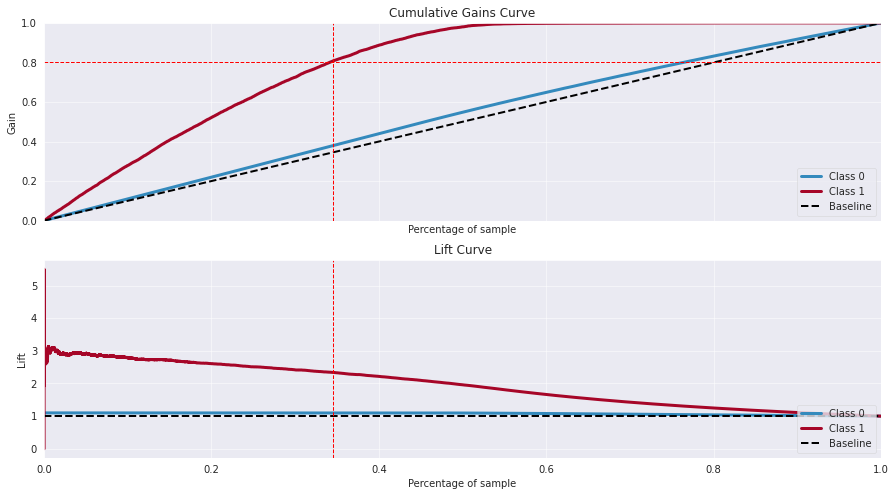

In [94]:
fig, ax = plt.subplots(2, 1,figsize=(15,8), sharex=True)
skplt.metrics.plot_cumulative_gain(y_test, prob, ax=ax[0])
ax[0].axhline(0.80, 0, 1, lw=1, ls='--', color='red')
ax[0].axvline(0.3454, 0, 1, lw=1, ls='--', color='red')
skplt.metrics.plot_lift_curve(y_test, prob, ax=ax[1])
ax[1].axvline(0.3454, 0, 1, lw=1, ls='--', color='red')
plt.show()


In [98]:
cust_34 = int(np.round(len(df_aux) * 0.3453, 0))

print(f'To reach 80% of interested customer the sales team need {cust_34} calls.')

To reach 80% of interested customer the sales team need 35093 calls
